In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using FFTW
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [2]:
import ReactiveMP.messageout

In [3]:
data_seed, params_seed = 42, 420;

## Generate signal

In [117]:
# Time horizon
T = 8000;

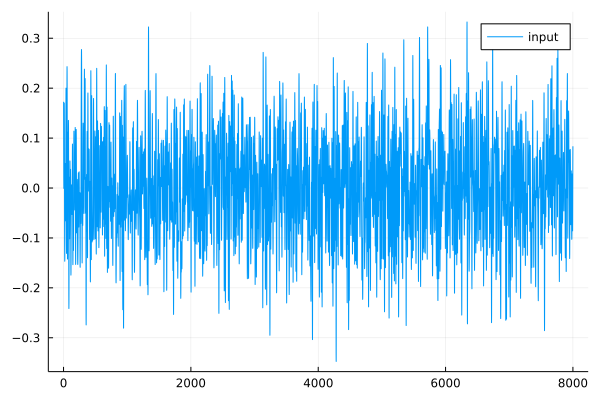

In [118]:
# Signal properties
N = 2^16
P = 1
M = 1
fMin = 0
fMax = 100
fs = 1000
type_signal = "odd"
uStd = 0.1

# Lines selection - select which frequencies to excite
f0 = fs/N
linesMin = Int64(ceil(fMin / f0) + 1)
linesMax = Int64(floor(fMax / f0) + 1)
lines = linesMin:linesMax

# Remove DC component
if lines[1] == 1; lines = lines[2:end]; end

if type_signal == "full"
    # do nothing
elseif type_signal == "odd"

    # remove even lines - odd indices
    if Bool(mod(lines[1],2)) # lines(1) is odd
        lines = lines[2:2:end]
    else
        lines = lines[1:2:end]
    end

elseif type_signal == "oddrandom"

    # remove even lines - odd indices
    if Bool(mod(lines[1],2)) # lines(1) is odd
        lines = lines[2:2:end]
    else
        lines = lines[1:2:end]
    end

    # remove 1 out of nGroup lines
    nLines = length(lines)
    nRemove = floor(nLines / nGroup)
    removeInd = rand(1:nGroup, [1 nRemove])
    removeInd = removeInd + nGroup*[0:nRemove-1]
    lines = lines(!removeInd)
end
nLines = length(lines)

# multisine generation - frequency domain implementation
U = zeros(ComplexF64, N,M)

# excite the selected frequencies
U[lines,:] = exp.(2im*pi*rand(nLines,M))

# go to time domain
u = real(ifft(U))

# rescale to obtain desired rms std
u = uStd * u ./ std(u[:,1])

# generate P periods
syn_input = repeat(u, outer=(P,1))[1:T];

# Visualize
plot(syn_input, label="input")

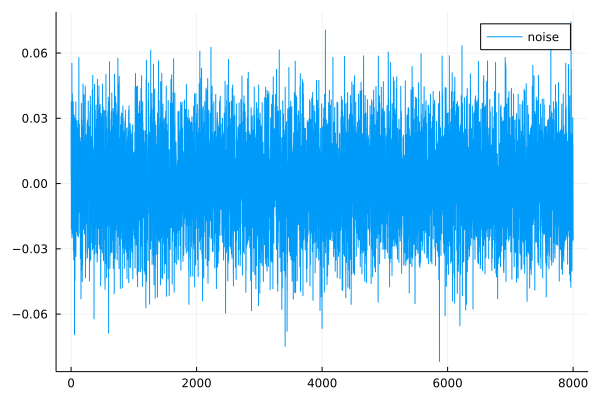

In [119]:
# True noise precision
w_true = 2500.

# Generate a noise sequence
syn_noise = sqrt(inv(w_true))*randn(T);

# Visualize noise
plot(syn_noise, label="noise")

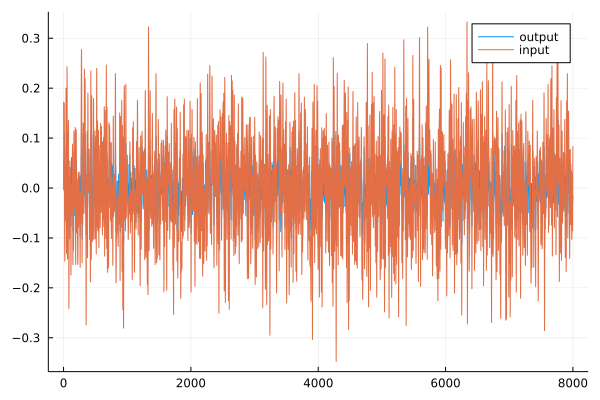

In [120]:
# Define parameters
η_true = 0.1*ones(full_order)
τ_true = 1e15

# Generate output signal
syn_output = zeros(T)
for k = 4:T
    
    # Fill delay vector
    z_k = [syn_input[k:-1:k-(delay_u-1)]; syn_output[k-1:-1:k-delay_y]; syn_noise[k-1:-1:k-delay_e]]
    
    # Generate output according to NARMAX model
    syn_output[k] = η_true'*z_k + syn_noise[k]
end

# Plot both input and outputs
plot(syn_output, label="output")
plot!(syn_input, label="input")

In [135]:
train_size = 6000
test_size = 1050

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

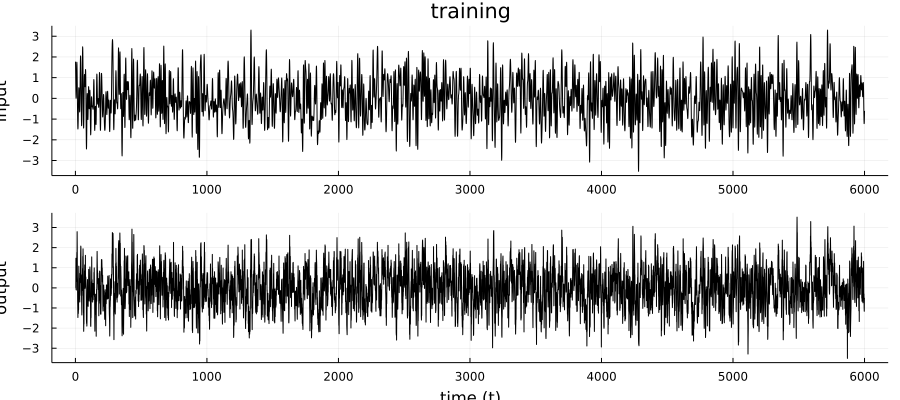

In [136]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

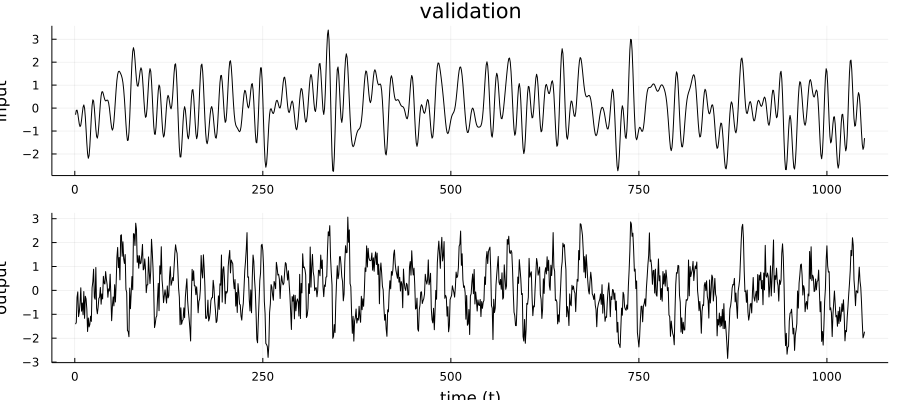

In [137]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## Model

In [138]:
# find order
delay_y, delay_u, delay_e = 2, (2+1), 2
order_h = delay_e + 1;

In [139]:
full_order = delay_e + delay_y + delay_u
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, delay_u); U[delay_y+1:delay_y+delay_u, 1:delay_u] = diageye(delay_u);
H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

In [140]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1
    
    obs_prec = 1e12;
    
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))}
    w       = randomvar()
    h       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}
        uh[t] ~ H*h[t] + Us[t]
        yuh[t] ~ uh[t] + Ys[t]
        yuh_[t] ~ AR(yuh[t], η, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ dot(yuh_[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, y_nodes, y
end

linear_max_mv (generic function with 1 method)

In [141]:
function linear_max_inference_mv(observations, observations_prev, controls;
                                 delay_y, delay_u, delay_e,
                                 h_prior=(randn(delay_e+1), diageye(delay_e+1)),
                                 w_prior=(1.0, 1.0), η_prior=(zeros(delay_y + delay_u + delay_e), diageye(delay_y + delay_u + delay_e)),
                                 τ_prior=(1.0, 1.0), vmp_its=10)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1

    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, y_nodes, y) = linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, delay_y, delay_u, delay_e,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, y_out_buffer
    
end

linear_max_inference_mv (generic function with 1 method)

In [142]:
# H = zeros(delay_e, order_h); H[1:end,end-delay_e+1:end] = diageye(delay_e);

In [143]:
@model [default_factorisation=MeanField()] function linear_max_mv_(n, h_prior, w_prior, η_priors, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_e
    order_h = delay_e + 1
    
    obs_prec = 1e12;
    
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))}
    w       = randomvar()
    h       = randomvar(n)
    u_      = randomvar(n)
    x       = randomvar(n)
    ux      = randomvar(n)
    h_      = randomvar(n)
    xuh_    = randomvar(n)
    y       = datavar(Float64, n)
    Hh      = randomvar(n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
    ηx   ~ MvNormalMeanPrecision(mean(η_priors[1]), precision(η_priors[1]))
    ηu   ~ MvNormalMeanPrecision(mean(η_priors[2]), precision(η_priors[2]))
    ηh   ~ MvNormalMeanPrecision(mean(η_priors[3]), precision(η_priors[3]))
    
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}

        u_[t] ~ dot(u[t], ηu)
        x[t]  ~ dot(y_prev[t], ηx)
        ux[t] ~ u_[t] + x[t]
        
        Hh[t] ~ H*h[t]
        h_[t] ~ AR(Hh[t], ηh, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        xuh_[t] ~ ux[t] + dot(h_[t], b)
        
        y_nodes[t], y[t] ~ xuh_[t] + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, ηh, ηu, ηx, τ, y_nodes, y, h_, x, ux, u_, Hh
end

linear_max_mv_ (generic function with 1 method)

In [144]:
function linear_max_inference_mv_(observations, observations_prev, controls;
                                 delay_y, delay_u, delay_e,
                                 h_prior=(randn(delay_e+1), diageye(delay_e+1)),
                                 w_prior=(1.0, 1.0), η_priors,
                                 τ_prior=(1.0, 1.0), vmp_its=10)
    
    order = delay_e
    order_h = delay_e + 1

    n = length(observations)

    # define model
    model, (θ, w, h, ηh, ηu, ηx, τ, y_nodes, y, h_, x, ux, u_, Hh) = linear_max_mv_(n, h_prior, w_prior, η_priors, τ_prior, observations_prev, controls, delay_y, delay_u, delay_e,
                                                                 options = (limit_stack_depth = 100, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer  = nothing
    w_buffer  = nothing
    ηx_buffer = nothing
    ηu_buffer = nothing
    ηh_buffer = nothing
    τ_buffer  = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    
    subscribe!(getmarginal(ηh), (x) -> ηh_buffer = x)
    subscribe!(getmarginal(ηu), (x) -> ηu_buffer = x)
    subscribe!(getmarginal(ηx), (x) -> ηx_buffer = x)
    
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmessages!(x, NormalMeanPrecision(0.0, 1.0))
    setmessages!(u_, NormalMeanPrecision(0.0, 1.0))
    setmessages!(ux, NormalMeanPrecision(0.0, 1.0))
    setmessages!(Hh, MvNormalMeanPrecision(zeros(order), diageye(order)))
    
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    
    setmarginal!(ηx, MvNormalMeanPrecision(mean(η_priors[1]), precision(η_priors[1])))
    setmarginal!(ηu, MvNormalMeanPrecision(mean(η_priors[2]), precision(η_priors[2])))
    setmarginal!(ηh, MvNormalMeanPrecision(mean(η_priors[3]), precision(η_priors[3])))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmessages!(h_, MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e)))

    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, ηx_buffer, ηu_buffer, ηh_buffer, τ_buffer, y_out_buffer
    
end

linear_max_inference_mv_ (generic function with 1 method)

In [145]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [148]:
train_size = 5000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [149]:
include("../helpers/nonlinear_node.jl")

In [150]:
full_order = delay_y + delay_u + delay_e
coefs_precision = 1e3*diageye(full_order)
coefs_mean = 0.1*ones(full_order);
# coefs_mean = randn(full_order); 
# coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# coefs_precision[end-delay_e+1:end,end-delay_e+1:end] = 1e5*diageye(delay_e)
# coefs_precision[1:3, 1:3] = 1e3*diageye(3)
# coefs_precision[4:7, 4:7] = 1e-10*diageye(4)
# coefs_precision[7:end, 7:end] = 1e3*diageye(4)

In [151]:


fe_, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_train, X_train, U_train, delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, w_prior=(1e4, 1.0), η_prior=(coefs_mean, coefs_precision), τ_prior=(1e2, 1.0), vmp_its=100);



Progress: 100%|█████████████████████████████████████████| Time: 0:03:22


In [152]:
# full_order = delay_y + delay_u + delay_e
# coefs_precision = diageye(full_order)
# coefs_mean = zeros(full_order); coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# eta_priors = [MvNormalMeanPrecision(zeros(delay_y), diageye(delay_y)), MvNormalMeanPrecision(zeros(delay_u), diageye(delay_u)), MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))]

# fe_, h_, θ_, w_, ηx_, ηu_, ηh_, τ_, y_out_ = linear_max_inference_mv_(Y_train, X_train, U_train, delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, w_prior=(1e4, 1.0), η_priors=eta_priors, τ_prior=(1e2, 1.0), vmp_its=100);


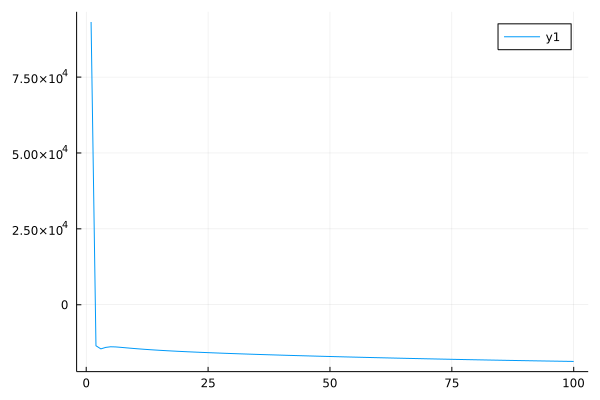

In [159]:
plot(fe_)

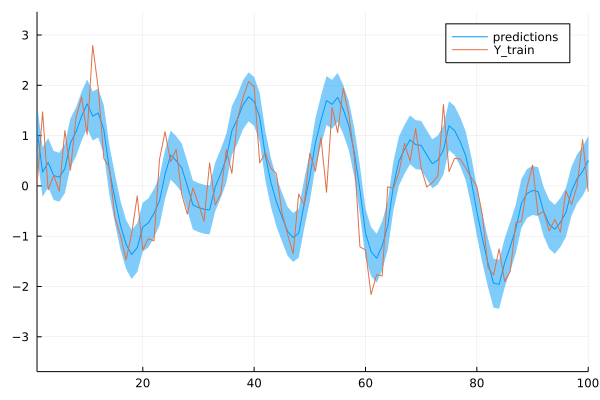

In [162]:
mfrom, mto = 1, 100
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [163]:
mean(w_)

9997.072192928841

In [164]:
mean(τ_)

55.42951631518077

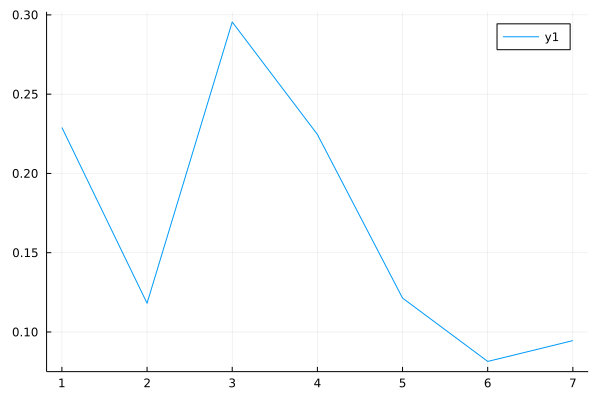

In [165]:
plot(mean(η_))

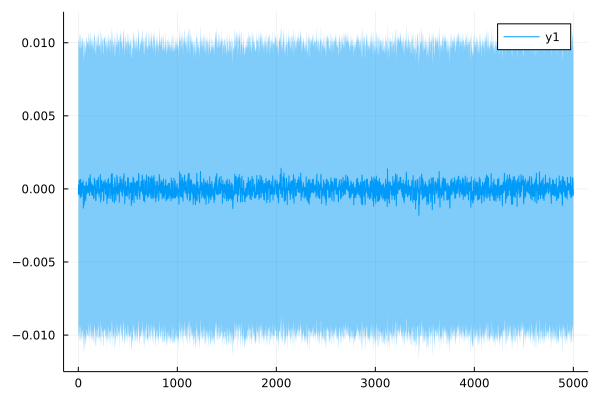

In [166]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction

In [167]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [168]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    Ys = Y*y_prev
    Us = U*u
    h_ = @call_rule typeof(*)(:out, Marginalisation) (m_A=PointMass(H), m_in=h_out)
    uh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Us), m_in2=h_)
    yuh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Ys), m_in2=uh)
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=yuh, q_θ=η_posterior.data, q_γ=τ_posterior.data, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)
end

prediction (generic function with 1 method)

In [169]:
h_prior = h_[end]
prediction(h_prior, mean(w_), η_, τ_, X_test[1], U_test[1], full_order=full_order, h_order=order_h)

NormalMeanVariance{Float64}(μ=-0.5576957589657745, v=0.23711567788984253)

In [170]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    _, h_post, θ_post, w_post, η_post, τ_post, _ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], 
                                                                            delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                            h_prior=(mean(h_prior), precision(h_prior)),
                                                                            w_prior=(shape(w_prior), rate(w_prior)), 
                                                                            η_prior=(mean(η_), precision(η_)),
                                                                            τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);
    h_prior = h_post[end]
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


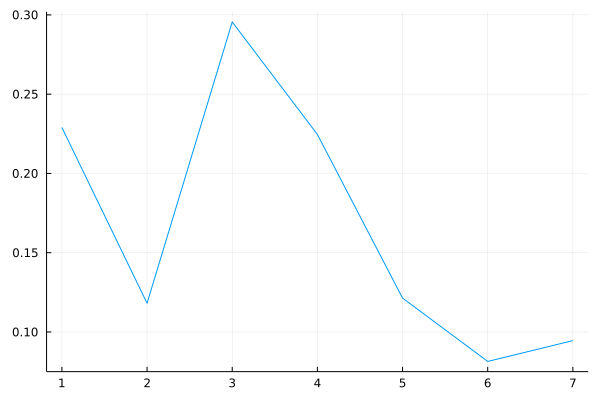

In [171]:
plot(mean(η_), label=false)

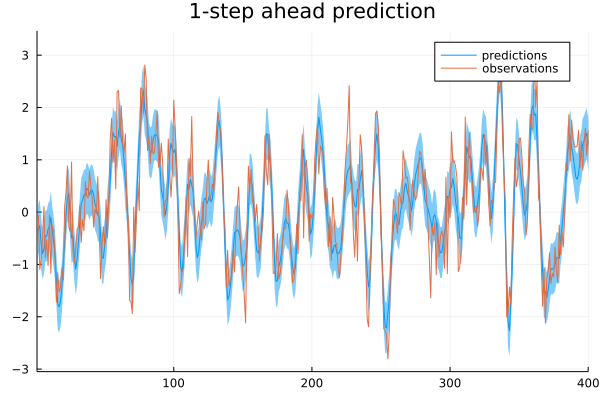

In [190]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 400), title="1-step ahead prediction", label="observations")

In [175]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.5132872411110637

In [176]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = [h_[end]]

ProgressMeter.@showprogress for i in 1:length(Y_test)
    _, h_post, θ_post, w_post, η_post, τ_post, y_out_post = linear_max_inference_mv([simulated_Y[i]], [simulated_X[i]], [U_test[i]],
                                                                                     delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                                     h_prior=(mean(h_prior), precision(h_prior)),
                                                                                     w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                     η_prior=(mean(η_prior), precision(η_prior)),
                                                                                     τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);


    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
    
    push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [188]:
zoom = 1:400
RMSE = sqrt(mean((simulated_Y[zoom] .- Y_test[zoom]).^2))

0.5785926233610926

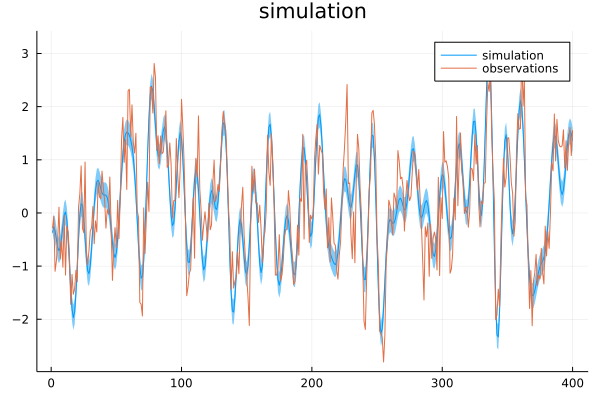

In [189]:
plot(simulated_Y[zoom.+1],  ribbon=simulated_Y_cov[zoom], label="simulation")
# plot!(first.(U_test[zoom]), label="controls")
plot!(Y_test[zoom], title="simulation", label="observations")